# GARCH Models - Portfolio At Risk

## Import Libraries

In [1]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import quandl

from datetime import date
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
p = print

p(sys.version)

# Machine: Linux x86_64

# 3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
# [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


3.6.2 |Anaconda, Inc.| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]


In [2]:
#import quandl

end = date(2018, 3, 1)
start = date(2017, 1, 1)

quandl.ApiConfig.api_key = 'tyBmrEJT4T56sTgfhsJK'

#mydata = quandl.get_table('ZACKS/FC', ticker='AAPL')
#mydata = quandl.get_table('ZACKS/FC', ticker='AAPL', qopts={'columns': ['ticker', 'per_end_date']})
#mydata = quandl.get("WIKI/AAPL", rows=500)
#mydata = quandl.get("WIKI/AAPL", rows=500, qopts={'columns': ['Date', 'Close']})
mydata = quandl.get("WIKI/AAPL")
mydata1 = quandl.get("WIKI/MSFT")
#mydata2 = quandl.get("EOD/SPYV")


#symbols = ['SPY','TLT','MSFT']

p(sys.version)

3.6.2 |Anaconda, Inc.| (default, Sep 19 2017, 08:03:39) [MSC v.1900 64 bit (AMD64)]


In [5]:
mydata.to_csv('C:\\Users\\Family\\Documents\\PythonScripts\\AAPL.csv')
mydata1.to_csv('C:\\Users\\Family\\Documents\\PythonScripts\\MSFT.csv')


In [6]:
mydata=pd.read_csv('C:\\Users\\Family\\Documents\\PythonScripts\\AAPL.csv')
mydata1=pd.read_csv('C:\\Users\\Family\\Documents\\PythonScripts\\MSFT.csv')

In [13]:
mydata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9398 entries, 1980-12-12 to 2018-03-23
Data columns (total 12 columns):
Open           9398 non-null float64
High           9398 non-null float64
Low            9398 non-null float64
Close          9398 non-null float64
Volume         9398 non-null float64
Ex-Dividend    9398 non-null float64
Split Ratio    9398 non-null float64
Adj. Open      9398 non-null float64
Adj. High      9398 non-null float64
Adj. Low       9398 non-null float64
Adj. Close     9398 non-null float64
Adj. Volume    9398 non-null float64
dtypes: float64(12)
memory usage: 954.5 KB


In [15]:
# raw adjusted close prices
data1 = mydata[['Adj. Close']]

# data after 1/1/2000 - reading from datetimeindex 
data = data1[date(2000,1,1):]

# log returns
lrets = np.log(data/data.shift(1)).dropna()

# dump sample
data.head

<bound method NDFrame.head of             Adj. Close
Date                  
2000-01-03    3.596463
2000-01-04    3.293170
2000-01-05    3.341362
2000-01-06    3.052206
2000-01-07    3.196784
2000-01-10    3.140559
2000-01-11    2.979917
2000-01-12    2.801283
2000-01-13    3.108431
2000-01-14    3.226985
2000-01-18    3.339435
2000-01-19    3.423611
2000-01-20    3.646583
2000-01-21    3.576222
2000-01-24    3.413651
2000-01-25    3.606422
2000-01-26    3.540238
2000-01-27    3.534133
2000-01-28    3.264897
2000-01-31    3.333330
2000-02-01    3.220881
2000-02-02    3.174616
2000-02-03    3.319194
2000-02-04    3.469876
2000-02-07    3.664575
2000-02-08    3.690599
2000-02-09    3.618310
2000-02-10    3.646583
2000-02-11    3.493973
2000-02-14    3.720800
...                ...
2018-02-09  155.970000
2018-02-12  162.710000
2018-02-13  164.340000
2018-02-14  167.370000
2018-02-15  172.990000
2018-02-16  172.430000
2018-02-20  171.850000
2018-02-21  171.070000
2018-02-22  172.600000
2018

In [7]:
# Time Series Plotting
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

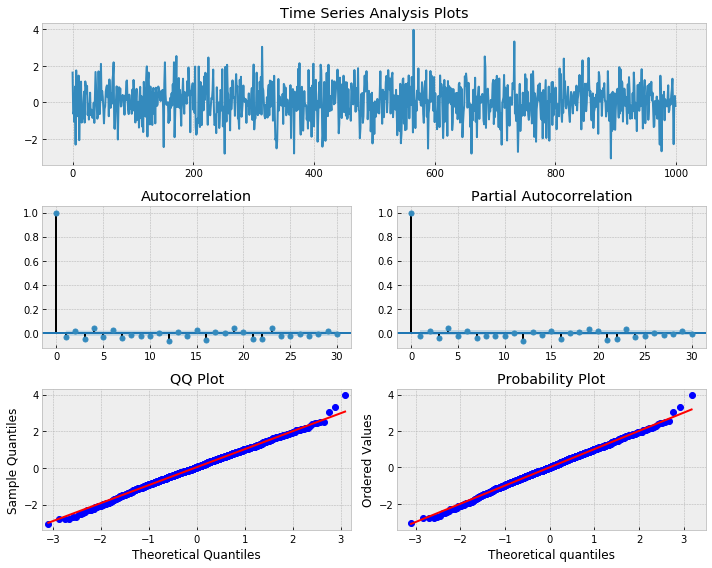

In [17]:
# Time Series Plot of a random seed
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

In [18]:
p("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

# Random Series
# -------------
# mean: 0.039 
# variance: 0.962
# standard deviation: 0.981

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


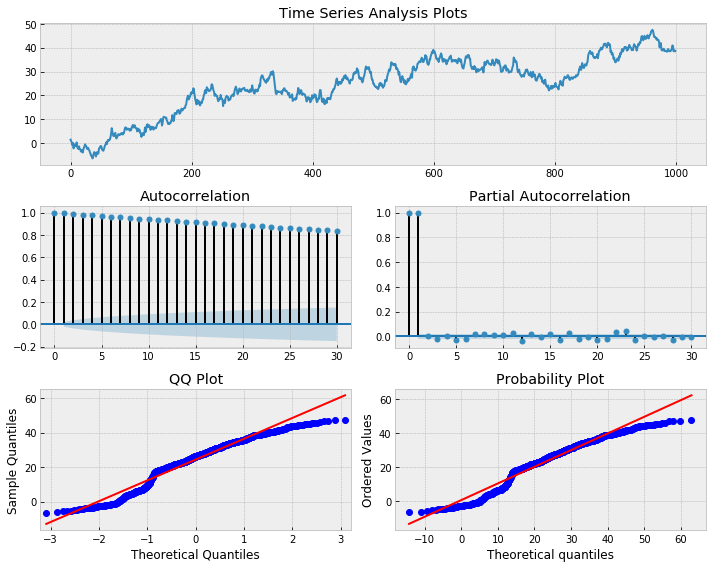

In [19]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

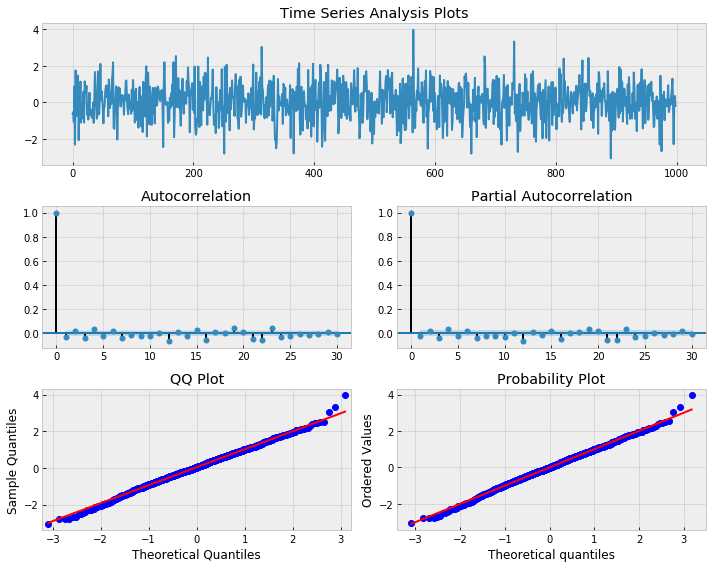

In [20]:
# First difference of simulated Random Walk series

_ = tsplot(np.diff(x), lags=30)

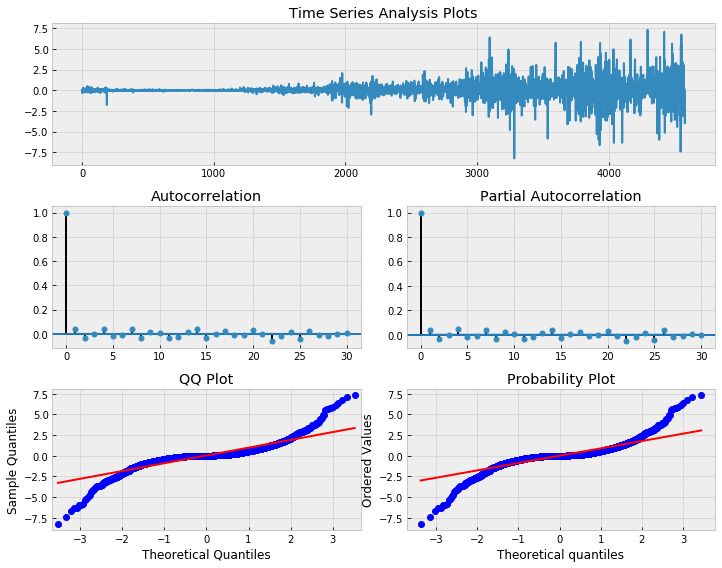

In [21]:
# First difference of AAPL prices
_ = tsplot(np.diff(data['Adj. Close']), lags=30)

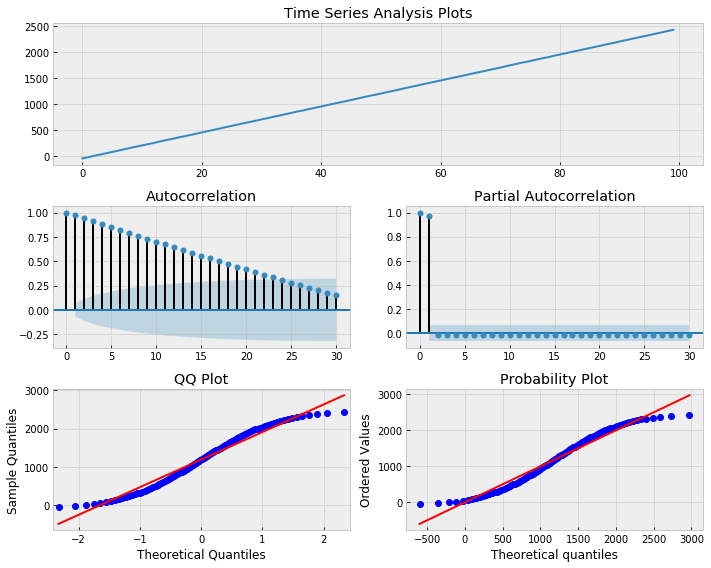

In [22]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30)  

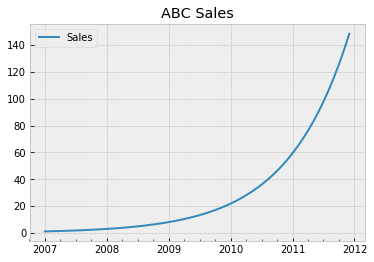

In [23]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

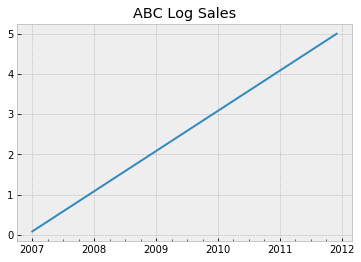

In [24]:
# ABC log sales 

with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

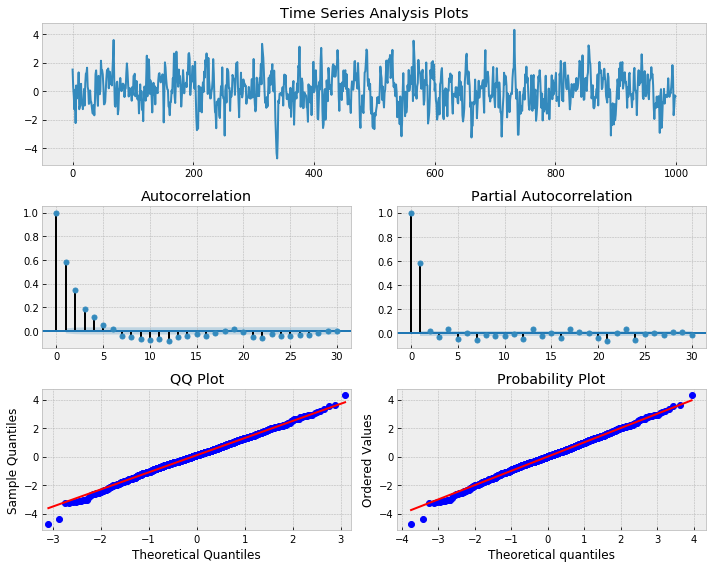

In [25]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

In [27]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'.format(a, true_order))

Wall time: 31.4 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


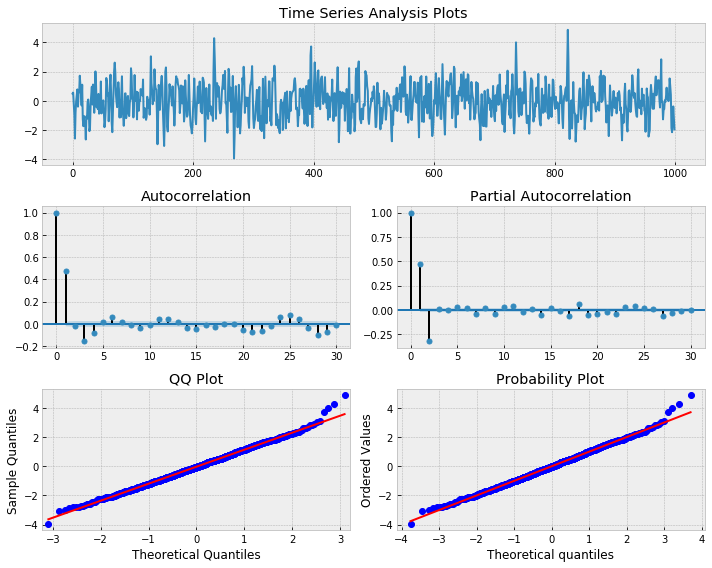

In [29]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

In [33]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.6291 -0.3196 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


In [34]:
MSFT = mydata1
MSFT.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
1986-03-13,25.50,29.25,25.5,28.00,3582600.0,0.0,1.0,0.058941,0.067609,0.058941,0.064720,1.031789e+09
1986-03-14,28.00,29.50,28.0,29.00,1070000.0,0.0,1.0,0.064720,0.068187,0.064720,0.067031,3.081600e+08
1986-03-17,29.00,29.75,29.0,29.50,462400.0,0.0,1.0,0.067031,0.068765,0.067031,0.068187,1.331712e+08
1986-03-18,29.50,29.75,28.5,28.75,235300.0,0.0,1.0,0.068187,0.068765,0.065876,0.066454,6.776640e+07
1986-03-19,28.75,29.00,28.0,28.25,166300.0,0.0,1.0,0.066454,0.067031,0.064720,0.065298,4.789440e+07


In [5]:
# Select best lag order for MSFT returns
# raw adjusted close prices
data1 = mydata1[['Adj. Close']]

# data after 1/1/2000 - reading from datetimeindex 
MSFT = data1[date(1985,1,1):]

# log returns
lrets = np.log(MSFT/MSFT.shift(1)).dropna()

lrets.head()

max_lag = 30
mdl = smt.AR(lrets['Adj. Close']).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets['Adj. Close']).select_order(maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

# best estimated lag order = 23

best estimated lag order = 4


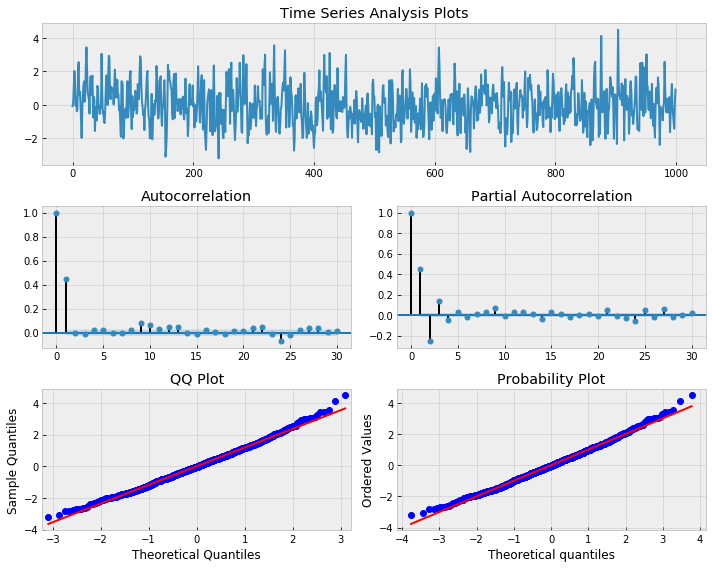

In [39]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30)

In [40]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1427.789
Method:                           mle   S.D. of innovations              1.009
Date:                Sun, 25 Mar 2018   AIC                           2859.578
Time:                        19:50:56   BIC                           2869.393
Sample:                             0   HQIC                          2863.308
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5898      0.025     23.604      0.000       0.541       0.639
                                    Roots                                    
                 Real           Imaginary           M

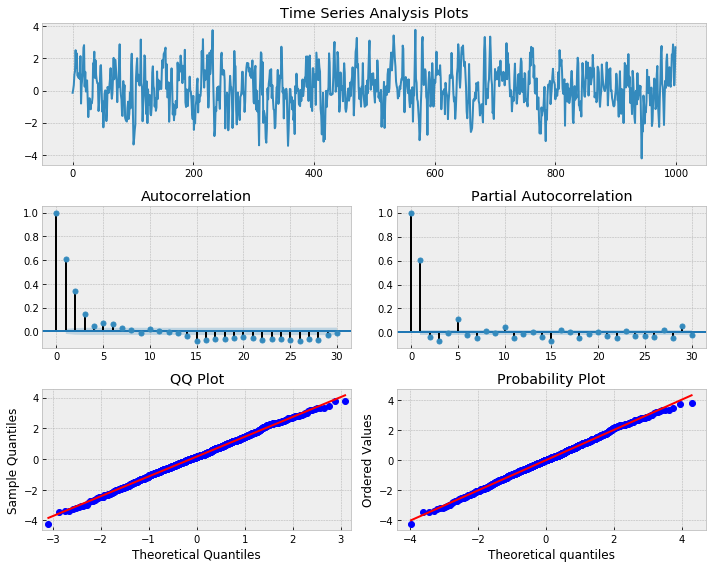

In [41]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30)

In [42]:
# Fit MA(3) model to simulated time series

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1438.010
Method:                           mle   S.D. of innovations              1.019
Date:                Sun, 25 Mar 2018   AIC                           2884.020
Time:                        19:55:14   BIC                           2903.651
Sample:                             0   HQIC                          2891.481
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6443      0.031     20.736      0.000       0.583       0.705
ma.L2.y        0.4364      0.036     12.182      0.000       0.366       0.507
ma.L3.y        0.2103      0.031      6.802      0.0

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7059.362
Method:                           mle   S.D. of innovations              0.993
Date:                Sun, 25 Mar 2018   AIC                          14128.725
Time:                        20:00:02   BIC                          14161.311
Sample:                             0   HQIC                         14140.145
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4574      0.054      8.426      0.000       0.351       0.564
ar.L2.y       -0.2409      0.015    -15.795      0.000      -0.271      -0.211
ma.L1.y        0.5236      0.055      9.487      0.0

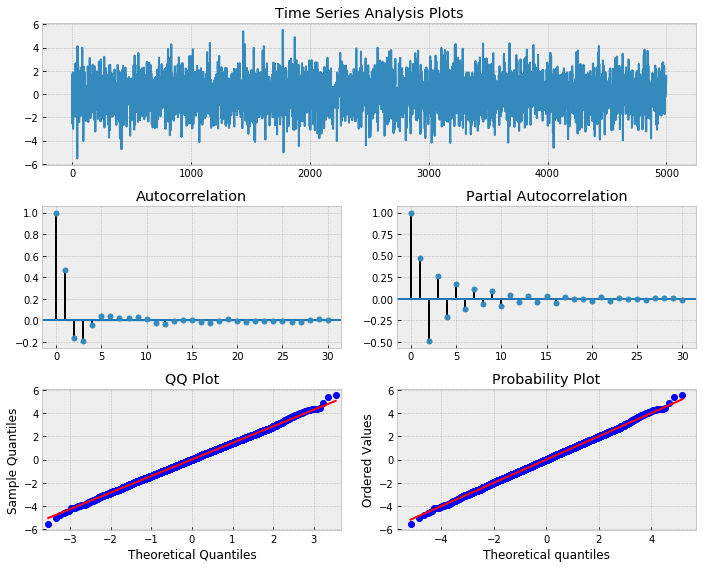

In [43]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag)

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
p(mdl.summary())

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


aic: 14136.93013 | order: (3, 2)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7062.465
Method:                           mle   S.D. of innovations              0.993
Date:                Sun, 25 Mar 2018   AIC                          14136.930
Time:                        20:07:41   BIC                          14176.033
Sample:                             0   HQIC                         14150.635
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5487      0.029     18.759      0.000       0.491       0.606
ar.L2.y       -0.2593      0.016    -15.989      0.000      -0.291      -0.228
ar.L3.y        0.40

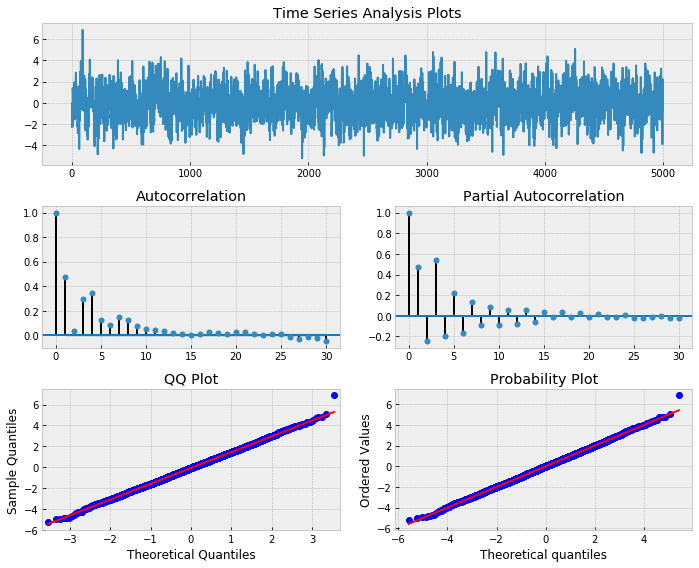

In [46]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag)

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
p(best_mdl.summary())

# aic: 14108.27213 | order: (3, 2)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Program Files (x86)\Microsoft Visual S

aic: -38980.08336 | order: (4, 1, 1)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


                             ARIMA Model Results                              
Dep. Variable:           D.Adj. Close   No. Observations:                 8073
Model:                 ARIMA(4, 1, 1)   Log Likelihood               19496.042
Method:                           mle   S.D. of innovations              0.022
Date:                Mon, 26 Mar 2018   AIC                         -38980.083
Time:                        18:57:12   BIC                         -38938.106
Sample:                    03-17-1986   HQIC                        -38965.722
                         - 03-26-2018                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
ar.L1.D.Adj. Close     0.0032      0.011      0.289      0.773      -0.019       0.025
ar.L2.D.Adj. Close    -0.0479      0.011     -4.298      0.000      -0.070      -0.026
ar.L3.D.Adj. Close  

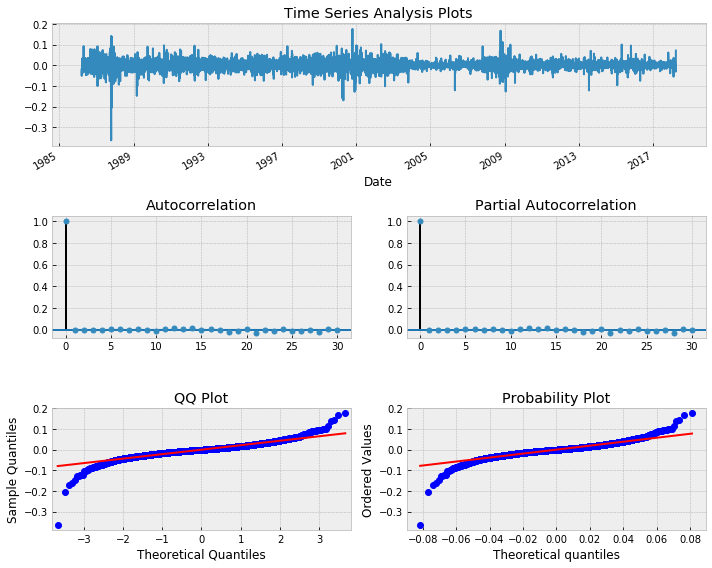

In [8]:
# Fit ARIMA(p, d, q) model to MSFT Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets['Adj. Close'], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)
p(best_mdl.summary())

In [10]:
# Create a 21 day forecast of MSFT returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(MSFT.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-03-26,0.003661,-0.038706,-0.052019,0.046028,0.059340
2018-03-27,-0.000885,-0.043252,-0.056565,0.041483,0.054795
2018-03-28,-0.000904,-0.043318,-0.056646,0.041510,0.054837
2018-03-29,-0.001096,-0.043531,-0.056865,0.041340,0.054674
2018-03-30,0.000849,-0.041598,-0.054936,0.043295,0.056633


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


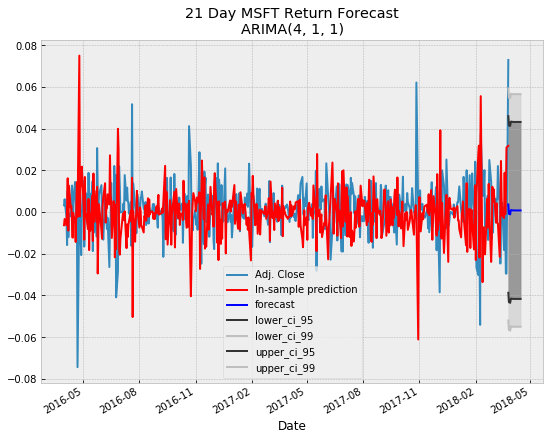

In [12]:
# Plot 21 day forecast for MSFT returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.iloc[-500:].copy()
ts.plot(ax=ax, label='MSFT Returns')
# in sample prediction
pred = best_mdl.predict(ts.index[0], ts.index[-1])
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day MSFT Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

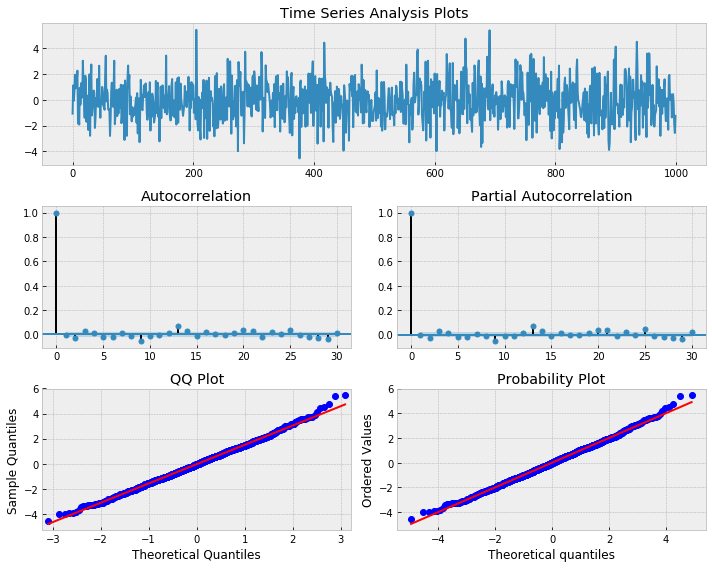

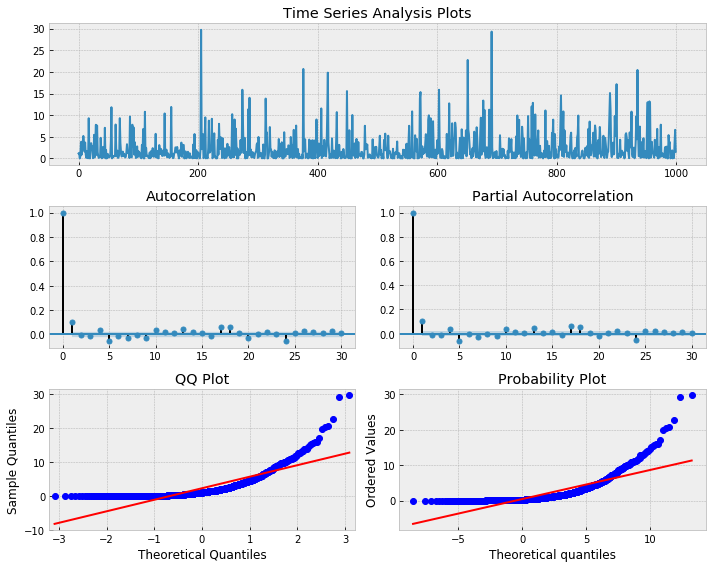

In [16]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
_ = tsplot(Y, lags=30)
_ = tsplot(Y**2, lags=30)


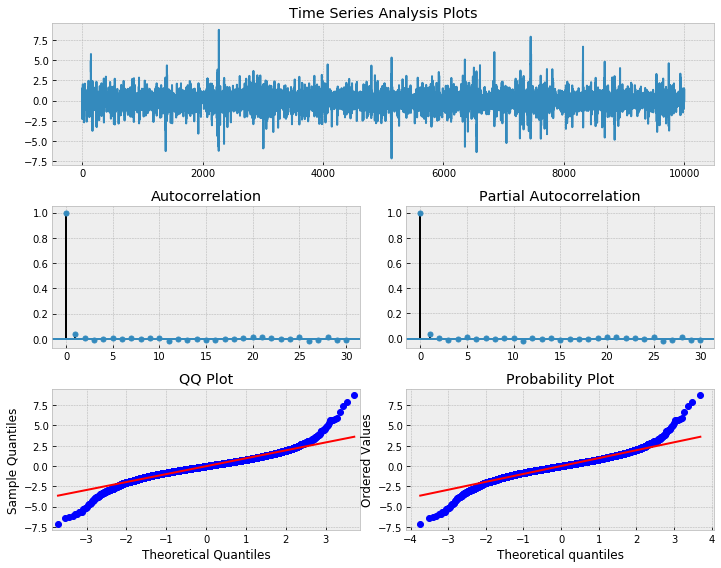

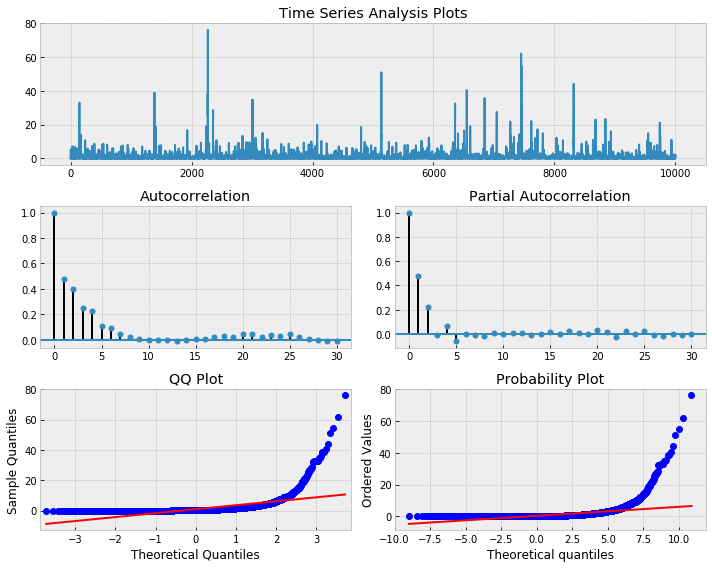

In [15]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30)
_ = tsplot(eps**2, lags=30)

In [17]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
p(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Mon, Mar 26 2018   Df Residuals:                     9996
Time:       

In [18]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.ix['2012':'2018']
res_tup = _get_best_model(TS)

# aic: -5255.56673 | order: (3, 0, 2)

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).t

aic: -8888.85531 | order: (4, 0, 2)


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


aic: -38980.08336 | order: (4, 1, 1)
                              ARMA Model Results                              
Dep. Variable:             Adj. Close   No. Observations:                 8074
Model:                     ARMA(4, 2)   Log Likelihood               19493.320
Method:                           mle   S.D. of innovations              0.022
Date:                Mon, 26 Mar 2018   AIC                         -38972.640
Time:                        19:32:47   BIC                         -38923.665
Sample:                    03-14-1986   HQIC                        -38955.885
                         - 03-26-2018                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
ar.L1.Adj. Close    -0.0917      0.469     -0.196      0.845      -1.011       0.828
ar.L2.Adj. Close    -0.1969      0.267     -0.739      0.460      -0.719    

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


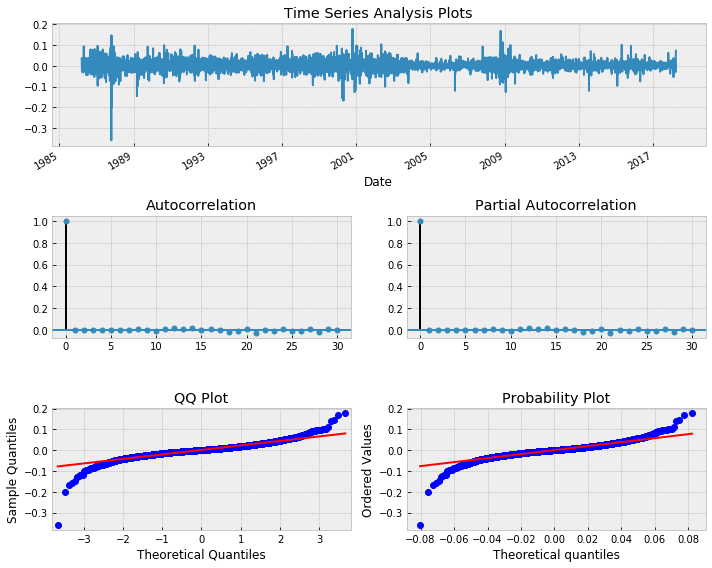

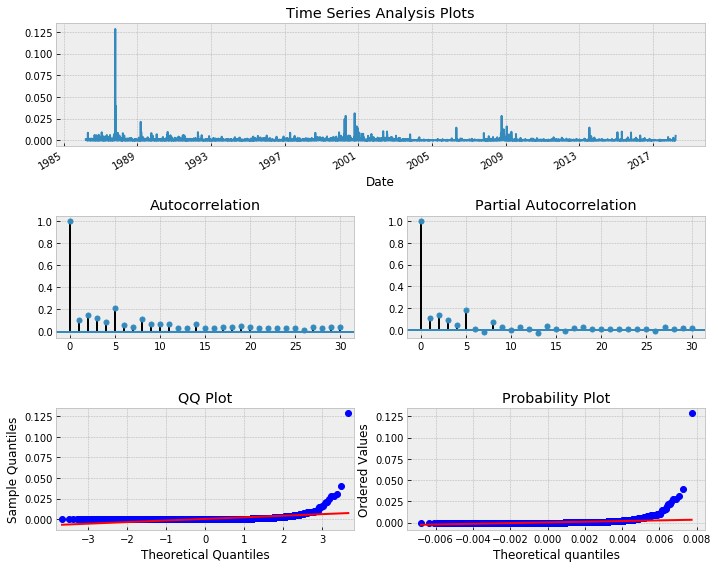

In [21]:
# Fit ARIMA(p, d, q) model to MSFT Returns 
# use best order / final model above

best_mdl = None
best_mdl = smt.ARIMA(lrets['Adj. Close'], order=(4,0,2)).fit(method='mle', trend='nc')

p('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 2)

p(best_mdl.summary())

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)
_ = tsplot(best_mdl.resid**2, lags=30)



In [26]:
# Now we can fit the arch model using the best fit arima model parameters

p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
p(res.summary())
_ = 

                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Adj. Close   R-squared:                      -0.018
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.018
Vol Model:                        GJR-GARCH   Log-Likelihood:                3802.85
Distribution:      Standardized Student's t   AIC:                          -7587.71
Method:                  Maximum Likelihood   BIC:                          -7539.50
                                              No. Observations:                 1566
Date:                      Mon, Mar 26 2018   Df Residuals:                     1557
Time:                              19:47:55   Df Model:                            9
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\arch\univariate\base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                   Adj. Close   R-squared:                      -0.018
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.018
Vol Model:                        GJR-GARCH   Log-Likelihood:                3802.85
Distribution:      Standardized Student's t   AIC:                          -7587.71
Method:                  Maximum Likelihood   BIC:                          -7539.50
                                              No. Observations:                 1566
Date:                      Mon, Mar 26 2018   Df Residuals:                     1557
Time:                              19:47:55   Df Model:                            9
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

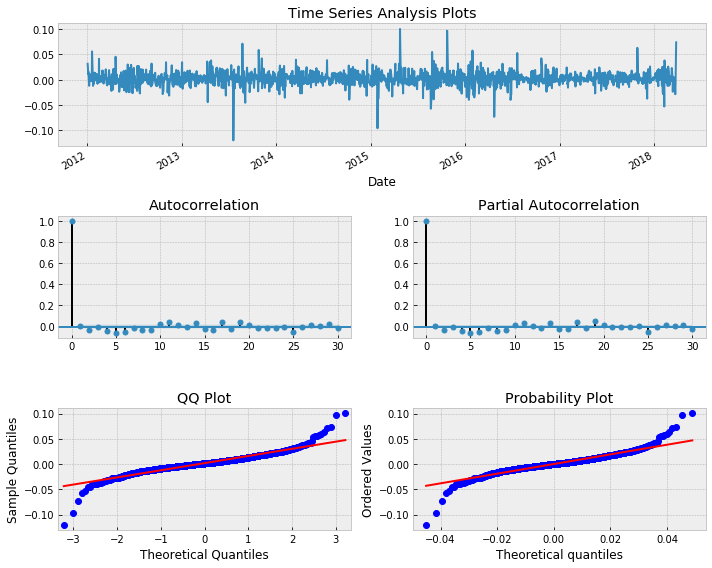

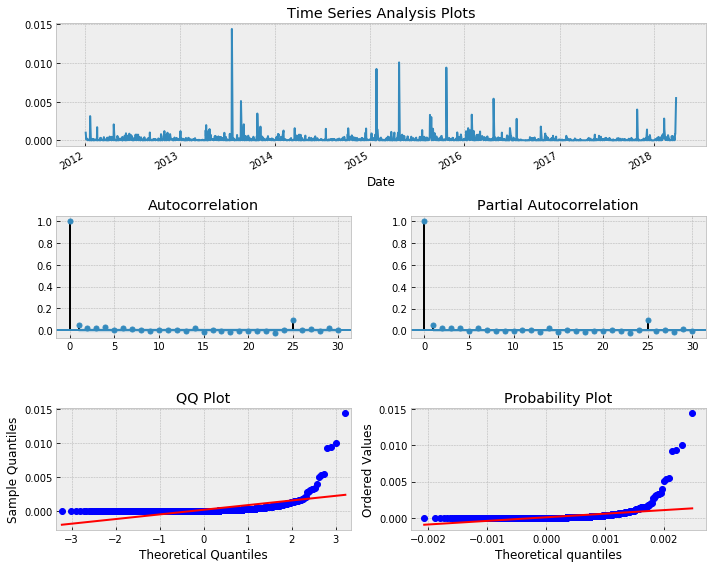

In [30]:
p(res.summary())
_ = tsplot(res.resid, lags=30)
_ = tsplot(res.resid**2, lags=30)
